In [1]:
import pandas as pd
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")
df1.values
df2.values

array([[ 53, 110,  80, ...,  38,   0,   9],
       [ 48, 104, 102, ...,  72,  67,  26],
       [ 45,  67,  81, ...,  11,   0,   2],
       ...,
       [204, 215, 383, ...,  23,   8,  10],
       [ 50, 116, 100, ...,  27,   9,  11],
       [ 30,  47,  61, ...,  15,   0,   5]])

In [2]:
import torch
import numpy as np

np_array = np.array(df1)

In [3]:
np_array

array([[ 24,  51,  44, ...,  27,   0,   3],
       [ 22,  31, 214, ...,   0,   0,   2],
       [ 84, 126, 239, ...,  24,   8,   9],
       ...,
       [268, 358, 277, ...,  47,   7,   5],
       [ 81, 116,  90, ...,   9,   0,   2],
       [118, 156, 197, ...,   0,   0,   5]])

In [4]:
df1

,POS_0_9_CP,POS_10_19_CP,POS_20_29_CP,POS_30_39_CP,POS_40_49_CP,POS_50_59_CP,POS_60_69_CP,POS_70_79_CP,POS_80_89_CP,POS_90_CP,DTH_CUM_CP
0,24,51,44,51,60,75,72,61,27,0,3
1,22,31,214,177,62,46,24,9,0,0,2
2,84,126,239,194,159,171,125,74,24,8,9
3,65,76,80,110,82,81,55,49,56,34,7
4,99,107,339,287,139,147,110,71,37,0,12
...,...,...,...,...,...,...,...,...,...,...,...
1039,86,201,206,202,240,317,225,138,48,0,7
1040,80,102,125,124,104,71,70,36,6,0,6
1041,268,358,277,415,355,332,215,107,47,7,5
1042,81,116,90,145,118,113,70,36,9,0,2


In [5]:
ds1 = torch.utils.data.TensorDataset(
    torch.tensor(df1.loc[:, "POS_0_9_CP":"POS_90_CP"].values),
    torch.tensor(df1.loc[:, ["DTH_CUM_CP"]].values)
)

ds2 = torch.utils.data.TensorDataset(
    torch.tensor(df2.loc[:, "POS_0_9_CP":"POS_90_CP"].values),
    torch.tensor(df2.loc[:, ["DTH_CUM_CP"]].values)
)

In [6]:
trainX, trainY = ds1[: :]
testX, testY = ds2[: :]

In [7]:
trainX = trainX.to(torch.float64)
trainY = trainY.to(torch.float64)
testX = testX.to(torch.float64)
testY = testY.to(torch.float64)

In [8]:
trainX

tensor([[ 24.,  51.,  44.,  ...,  61.,  27.,   0.],
        [ 22.,  31., 214.,  ...,   9.,   0.,   0.],
        [ 84., 126., 239.,  ...,  74.,  24.,   8.],
        ...,
        [268., 358., 277.,  ..., 107.,  47.,   7.],
        [ 81., 116.,  90.,  ...,  36.,   9.,   0.],
        [118., 156., 197.,  ...,  19.,   0.,   0.]], dtype=torch.float64)

In [9]:
trainY

tensor([[3.],
        [2.],
        [9.],
        ...,
        [5.],
        [2.],
        [5.]], dtype=torch.float64)

In [10]:
#q1 : about how many bytes does trainX consume?
trainX.nelement() * trainX.element_size()

83520

In [11]:
#q2 : what is the biggest difference we would have any one cell if we used float16 instead of float64?
biggest_val = -1.0
for cell in trainX:
    # print(cell)
    float16_X = cell.to(torch.float16)
    float16_X = float16_X.to(torch.float64)
    # print(torch.sum(float16_X))
    diff = abs(float16_X - cell)
    # torch.sum(diff)
    # print(torch.sum(diff).item())
    curr_val = torch.sum(diff).item()
    if curr_val > biggest_val:
        biggest_val = curr_val
biggest_val

0.0

In [12]:
#q3 : is a CUDA GPU available on your VM?
torch.cuda.is_available()

False

In [13]:
coef = torch.tensor([
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP
        [0.0300], # POS_60_69_CP
        [0.0300],
        [0.0300],
        [0.0300]
], dtype=trainX.dtype)
coef

tensor([[0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0300],
        [0.0300],
        [0.0300],
        [0.0300]], dtype=torch.float64)

In [14]:
#q4 : what is the predicted number of deaths for the first census tract?

(testX[:1, 0:10] @ coef).item()

9.844

In [15]:
#q5 : what is the average number of predicted deaths, over the whole testX dataset?

(testX[:, :] @ coef).mean().item()

12.073632183908048

In [16]:
import matplotlib.pyplot as plt

def f(x):
    return (x**2) - (8 * x) + 19

In [17]:
#q6 : first, what is y when x is a tensor containing 0.0?

x = torch.tensor(0.0, requires_grad=True)
y = f(x)
float(y)

19.0

3.9999430179595947

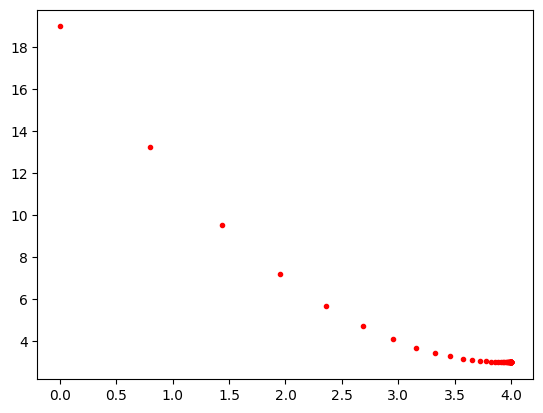

In [18]:
#q7 : what x value minimizes y?

optimizer = torch.optim.SGD([x], lr=0.1)

for epoch in range(50):
    y=f(x)
    plt.plot(x.detach(), y.detach(), "ro", markersize = 3)
    y.backward()
    optimizer.step()
    optimizer.zero_grad()
x.item()

In [19]:
trainX.shape

torch.Size([1044, 10])

In [20]:
trainY.shape

torch.Size([1044, 1])

In [21]:
coef = torch.zeros((10, 1), dtype=torch.float64)
trainX @ coef

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=torch.float64)

In [22]:
#q8 : what is the MSE (mean-square error) when we make predictions 
# using this vector of zero coefficients?

loss_fn = torch.nn.MSELoss()
coef = torch.zeros((10, 1), dtype=torch.float64)
predictions = trainX @ coef
mean_sqr_err = loss_fn(predictions, trainY)
mean_sqr_err.item()

197.8007662835249

In [23]:
torch.manual_seed(544)
ds = torch.utils.data.TensorDataset(trainX, trainY)
dl = torch.utils.data.DataLoader(ds, batch_size=50, shuffle=True)

In [24]:
 train, test = torch.utils.data.random_split(ds, [0.75, 0.25])

In [25]:
#q9 : what is the MSE over the training data, using the coefficients 
# resulting from the above training?

loss_fn = torch.nn.MSELoss()
coef = torch.zeros((10, 1), dtype=torch.float64, requires_grad=True)
optimizer = torch.optim.SGD([coef], lr=0.000002)

for epoch in range(500):
    for trainX, trainY in dl:
        X, Y = train[:]
        predictions = X @ coef
        loss = loss_fn(predictions, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # loss_fn(X @ coef, Y)

loss_fn(X @ coef, Y).item()

27.193642272717316

In [26]:
#q10 : what is the MSE over the test data?

torch.manual_seed(544)
ds = torch.utils.data.TensorDataset(testX, testY)
dl = torch.utils.data.DataLoader(ds, batch_size=50, shuffle=True)

loss_fn = torch.nn.MSELoss()
coef = torch.zeros((10, 1), dtype=torch.float64, requires_grad=True)
optimizer = torch.optim.SGD([coef], lr=0.000002)

for epoch in range(500):
    for trainX, trainY in dl:
        X,Y = test[:]
        predictions = X @ coef
        loss = loss_fn(predictions, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
loss_fn(X @ coef, Y).item()

23.269499963806357